In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import warnings
import joblib, pickle, os, re
import datetime
from datetime import datetime
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, 
                            VotingClassifier)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.tree import (DecisionTreeClassifier, ExtraTreeClassifier, plot_tree)
import sys
import dataviz
import xgboost
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRFClassifier
#from catboost import CatBoostClassifier
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
%matplotlib inline
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('paper')

warnings.filterwarnings(action='ignore')


## Objectif : 
 * Explorez les données pour chercher les plus grandes corrélation avec l'octroi ou non de crédit.
 * Développer un modèle de prédiction de scoring crédit
 * Créer un dockerfile pour le déploiement 
 * Héberger le code sur github ou gitlab.
 * Créer un tableau de bord interactif via Power BI ou Loocker Studio pour visualiser les résultats du modèle.  

### Données 
[German Credit Data](https://www.kaggle.com/code/mathchi/credit-risk-evaluation/notebook)

## Importing the data

In [1]:

test = pd.read_csv('/home/dona-erick/Test_Technique_DataBeez/German_Data_Credit/Test/german_credit_data.csv')
train= pd.read_csv('/home/dona-erick/Test_Technique_DataBeez/German_Data_Credit/Train/german_credit_data (1).csv')

In [2]:
train.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
test.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## Exploratory Data Analysis

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


In [6]:
columm_drop = ['Unnamed: 0']
train = train.drop(columns=columm_drop, axis = 1)
test=test.drop(columns =columm_drop, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [7]:
train.dtypes, train.duplicated().sum(), train.columns

(Age                  int64
 Sex                 object
 Job                  int64
 Housing             object
 Saving accounts     object
 Checking account    object
 Credit amount        int64
 Duration             int64
 Purpose             object
 Risk                object
 dtype: object,
 np.int64(0),
 Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
        'Credit amount', 'Duration', 'Purpose', 'Risk'],
       dtype='object'))

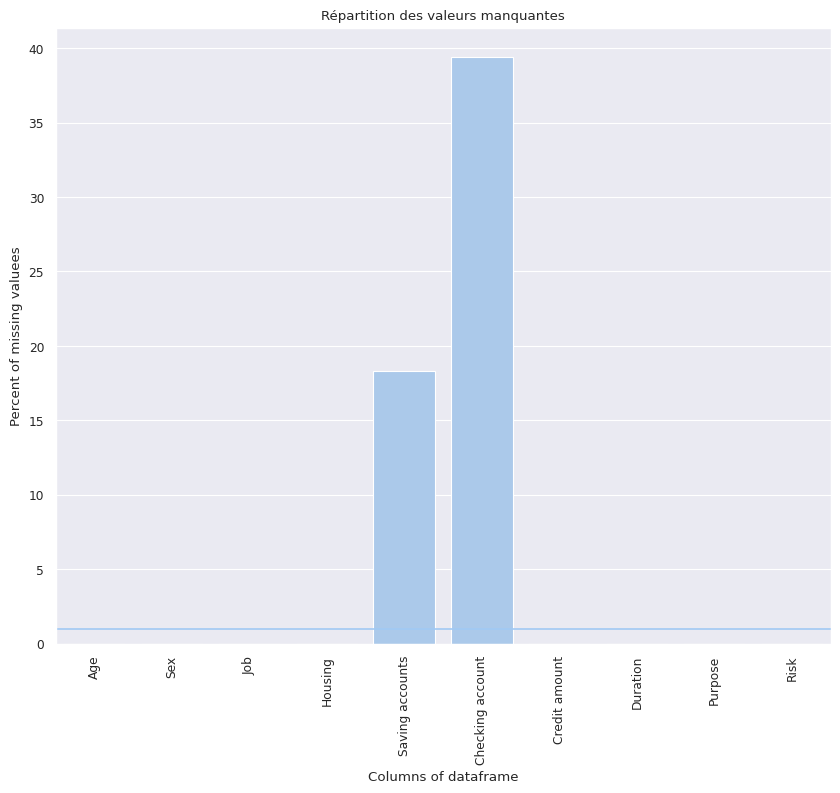

In [8]:
## identification des valeurs manquantes
missing_values = train.isnull().sum()
ratio_missing = (missing_values /train.shape[0])*100
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values.index, y = ratio_missing.values)
plt.title("Répartition des valeurs manquantes")
plt.xticks(rotation=90)
plt.xlabel('Columns of dataframe')
plt.ylabel("Percent of missing valuees")
plt.axhline(y=1.0, xmax=1,xmin=-1)
#plt.ylim(top=3)
plt.show()

In [9]:
ratio_missing

Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
Risk                 0.0
dtype: float64

####  1-) Analyse univariée

Sex


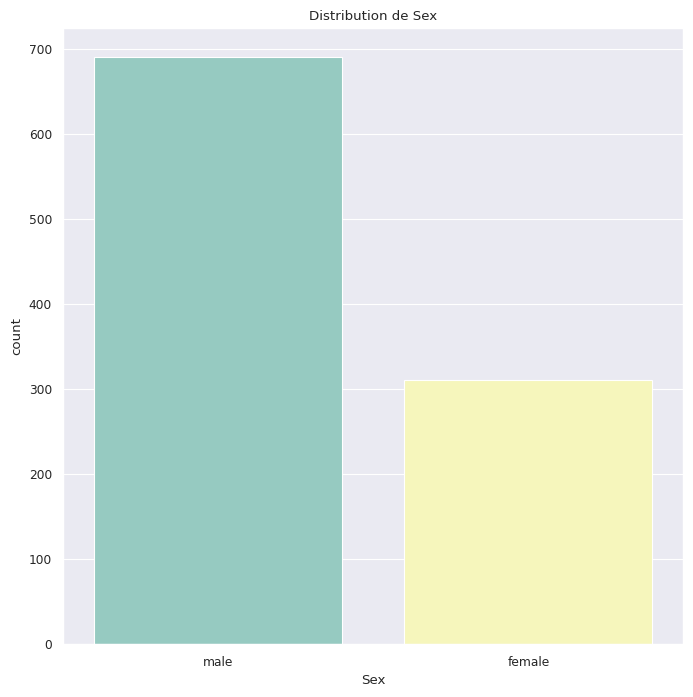

Housing


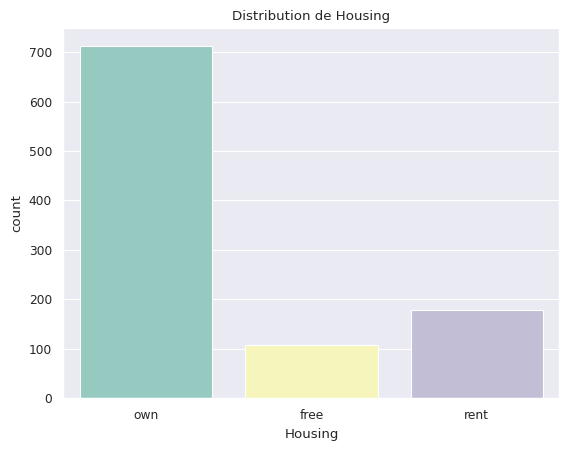

Saving accounts


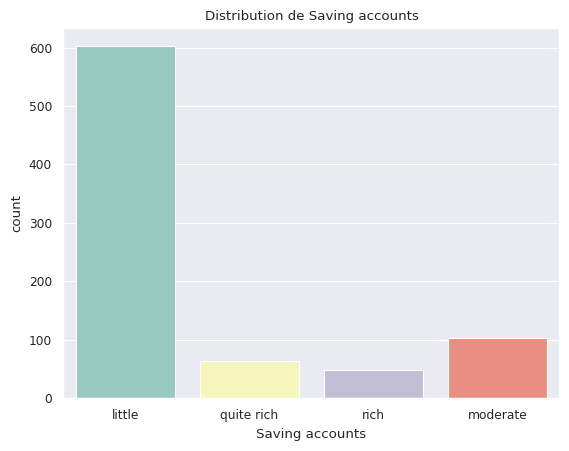

Checking account


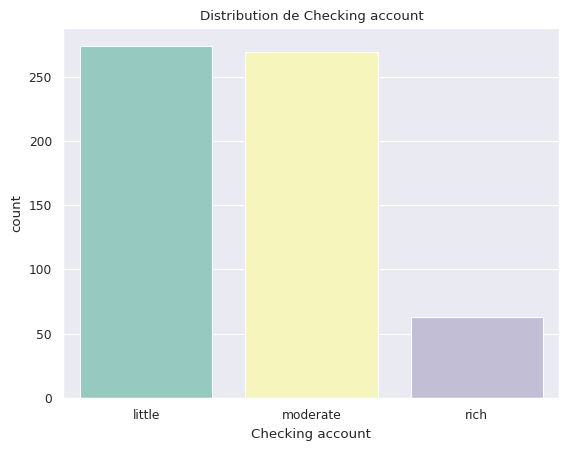

Purpose


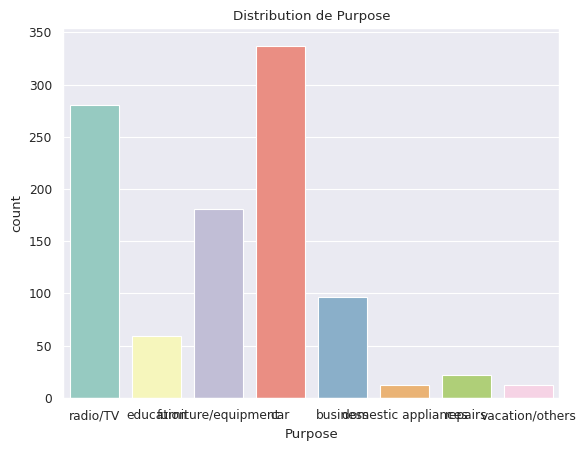

Risk


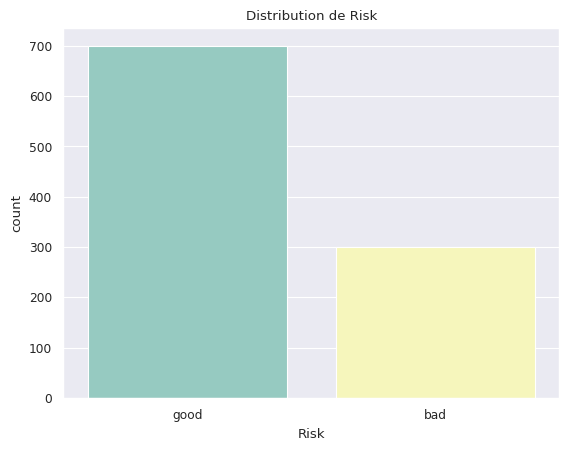

In [10]:
numerical_features = train.select_dtypes(exclude ='object')
categorical_features = train.select_dtypes(include='object')
sns.set_style(style='darkgrid')
plt.figure(figsize=(8, 8))
for var in categorical_features.columns:
    print(var)
    sns.countplot(data =train,x=var, palette='Set3')
    plt.title(f"Distribution de {var}")
    plt.xlabel(f'{var}')
    plt.show()

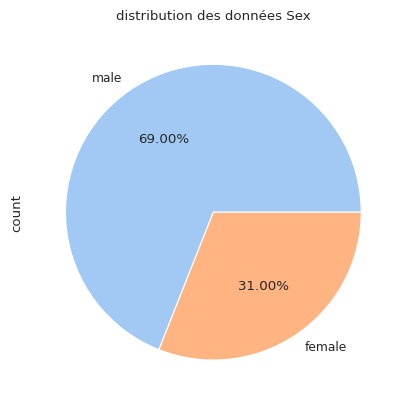

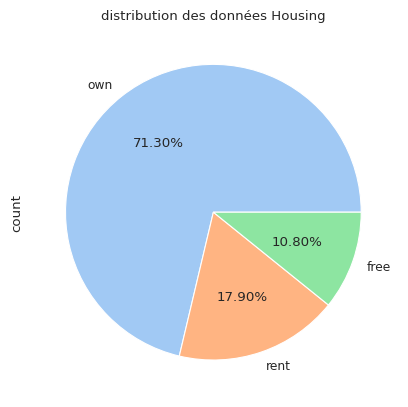

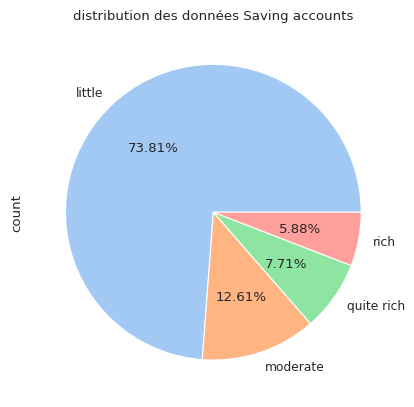

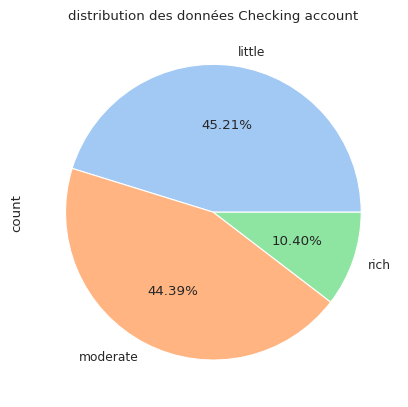

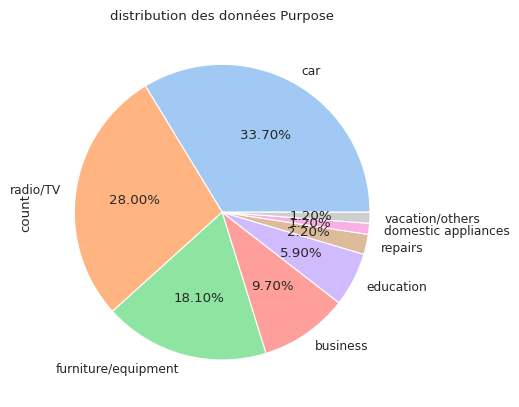

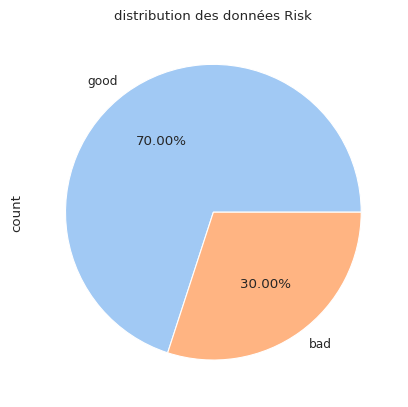

In [11]:
for col in categorical_features.columns:
    train[col].value_counts().plot(kind='pie', autopct='%.2f%%')
    plt.title(f'distribution des données {col}')
    plt.show()

In [12]:
target_count = train['Risk'].value_counts().reset_index()

fig=go.Figure(go.Bar(
    x=target_count['Risk'], y=target_count['count'], text=target_count['Risk'], #marker={'color': target_count['Risk']},
    textposition='outside')
            )
fig.update_layout(title_text = 'Countplot of Target', xaxis_title ='Risk' , yaxis_title ='count')
fig.show()

In [13]:

## Countplot of sex
sex_count = train['Sex'].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Sex'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Sex', xaxis_title='SEx',yaxis_title='Count')
fig.show()

## countplot of purpose
sex_count = train["Purpose"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Purpose'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Purpose', xaxis_title='Purpose',yaxis_title='Count')
fig.show()

## countplot of Cjecking account
sex_count = train["Checking account"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Checking account'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Checking account', xaxis_title='Checking account',yaxis_title='Count')
fig.show()

## countplot fo housing
sex_count = train["Housing"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Housing'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Housing', xaxis_title='Housing',yaxis_title='Count')
fig.show()

## countplot of saving amounts
sex_count = train['Saving accounts'].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Saving accounts'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Saving accounts', xaxis_title='Saving accounts',yaxis_title='Count')
fig.show()

In [14]:
## for numerical features

numerical_features = ['Age', 'Credit amount', 'Duration', 'Job'] 
fig = make_subplots(rows=3, cols=2, subplot_titles=None)

fig.add_trace(go.Histogram(x=train['Age'], name='Age'), row=1, col=1)
fig.add_trace(go.Histogram(x =train['Credit amount'], name='Credit Ammount'), row=2, col=2)
fig.add_trace(go.Histogram(x =train['Duration'], name='Duration'), row=3, col=1)
fig.add_trace(go.Histogram(x = train['Job'], name='Job'), row=3, col=2)

fig.update_layout(height=800, width=800, title_text = 'Hsitogramme des variables')
fig.show()

In [15]:
train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Features 
 * Âge (numérique)
    * Sexe (texte : masculin, féminin)
    * Emploi (numérique : 0 - non qualifié et non-résident, 1 - non qualifié et résident, 2 - qualifié, 3 - hautement qualifié)
    * Logement (texte : propre, loué ou gratuit)
    * Comptes d'épargne (texte - petit, modéré, assez riche, riche)
    * Compte courant (numérique, en DM - Deutsch Mark)
    * Montant du crédit (numérique, en DM)
    * Durée (numérique, en mois)
    * Objectif (texte : voiture, meubles/équipements, radio/TV, appareils électroménagers, réparations, éducation, affaires, vacances/autres)

In [16]:
df_good = train[train['Risk']=='good']
df_bad = train[train['Risk']=='bad']
df_good


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
...,...,...,...,...,...,...,...,...,...,...
994,50,male,2,own,NaN,NaN,2390,12,car,good
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good


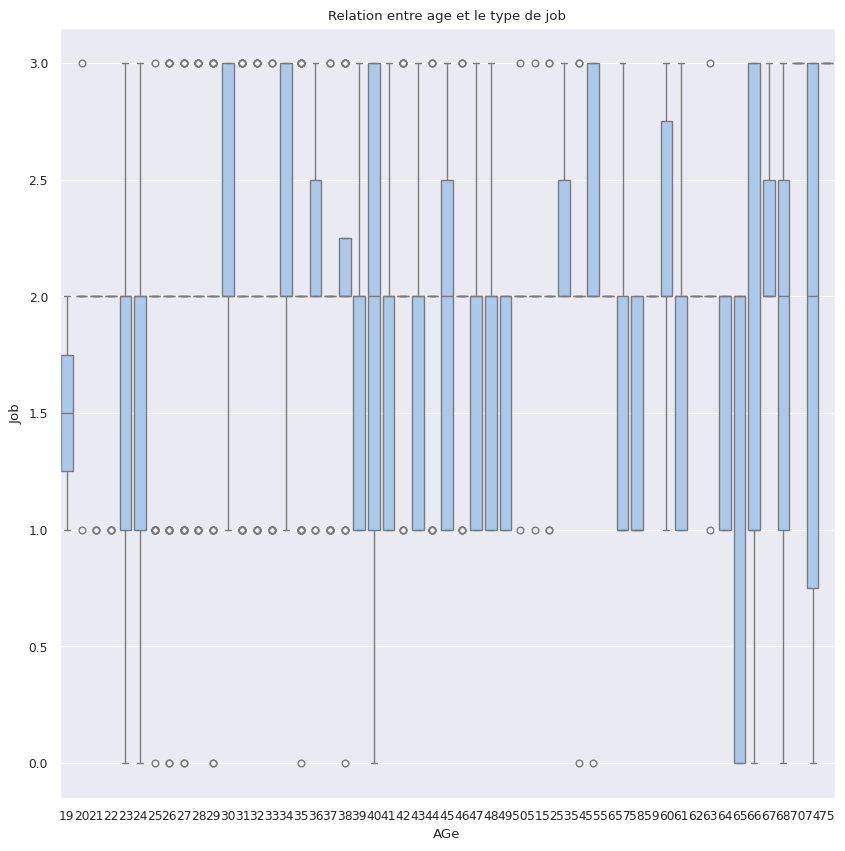

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.boxplot(data=train, x = 'Age', y='Job')
plt.title('Relation entre age et le type de job')
plt.xlabel(f'AGe')
plt.ylabel('Job')
plt.show()

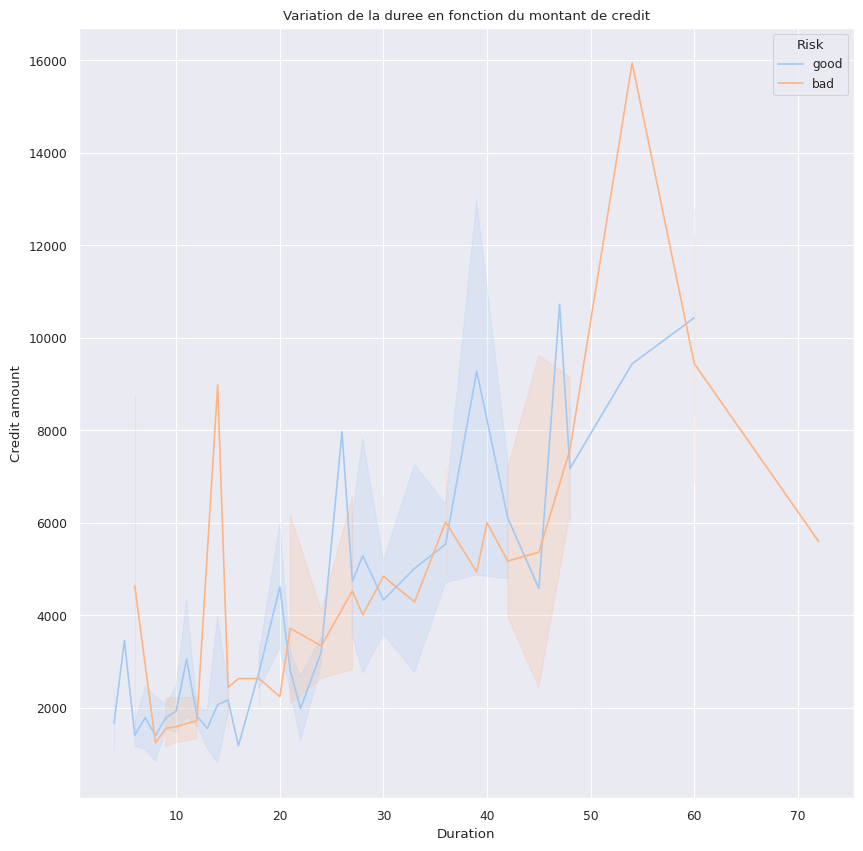

In [18]:
plt.figure(figsize=(10, 10))
sns.lineplot(data=train, x='Duration', y='Credit amount', hue = "Risk")
plt.title('Variation de la duree en fonction du montant de credit')
plt.xlabel('Duration')
plt.ylabel('Credit amount')
plt.show()

##### Good risk

In [19]:
fig = make_subplots(rows=3, cols=2, subplot_titles=None)

fig.add_trace(go.Histogram(x=df_good['Age'], name='Age'), row=1, col=1)
fig.add_trace(go.Histogram(x =df_good['Credit amount'], name='Credit Ammount'), row=2, col=2)
fig.add_trace(go.Histogram(x =df_good['Duration'], name='Duration'), row=3, col=1)
fig.add_trace(go.Histogram(x = df_good['Job'], name='Job'), row=3, col=2)

fig.update_layout(height=800, width=800, title_text = 'Hsitogramme des variables dont le risque de credit est bon')
fig.show()

#### Bad risk

In [20]:
fig = make_subplots(rows=3, cols=2, subplot_titles=None)

fig.add_trace(go.Histogram(x=df_bad['Age'], name='Age'), row=1, col=1)
fig.add_trace(go.Histogram(x =df_bad['Credit amount'], name='Credit Ammount'), row=2, col=2)
fig.add_trace(go.Histogram(x =df_bad['Duration'], name='Duration'), row=3, col=1)
fig.add_trace(go.Histogram(x = df_bad['Job'], name='Job'), row=3, col=2)

fig.update_layout(height=800, width=800, title_text = 'Hsitogramme des variables dont le risque de credit est mauvais')
fig.show()

## Identifiying the correlation

In [21]:
## method spearman

correlation_spearman= train.select_dtypes(exclude='object').corr(method='spearman')

### method de pearson
correlation_pearson= train.select_dtypes(exclude='object').corr(method='pearson')
## methode de kendall
correlation_kdenall= train.select_dtypes(exclude='object').corr(method='kendall')

print(f"Corrlation de spearman\n: {correlation_spearman}\n")
print(f"Corrlation de pearson\n: {correlation_pearson}\n")
print(f"Corrlation de kendall\n: {correlation_kdenall}\n")

Corrlation de spearman
:                     Age       Job  Credit amount  Duration
Age            1.000000  0.041327       0.026298 -0.036316
Job            0.041327  1.000000       0.298345  0.227266
Credit amount  0.026298  0.298345       1.000000  0.624709
Duration      -0.036316  0.227266       0.624709  1.000000

Corrlation de pearson
:                     Age       Job  Credit amount  Duration
Age            1.000000  0.015673       0.032716 -0.036136
Job            0.015673  1.000000       0.285385  0.210910
Credit amount  0.032716  0.285385       1.000000  0.624984
Duration      -0.036136  0.210910       0.624984  1.000000

Corrlation de kendall
:                     Age       Job  Credit amount  Duration
Age            1.000000  0.034113       0.017308 -0.025186
Job            0.034113  1.000000       0.236032  0.187245
Credit amount  0.017308  0.236032       1.000000  0.465738
Duration      -0.025186  0.187245       0.465738  1.000000



<Axes: >

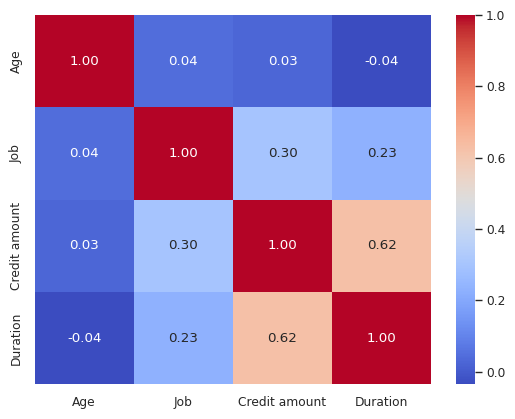

In [22]:
correlation_spearman= train.select_dtypes(exclude='object').corr(method='spearman')
sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', fmt='.2f')

Des resultats des correlations simples calculés , on peut deja constater que les variables credit_ammount et job sont corréles avec des valeurs respectives :
  * job- credit amount = 0.30
  * job-duration =0.23
  * credit amount -Duration =0.62

Mais on pourrait aller plus loin en faisant un test de krushkall pour identifer les correlation entre toutes les variables 

## Test de Krushkall-wallis

In [23]:
from scipy.stats import kruskal

categorical_vars = ['Sex', "Housing", "Saving accounts", 'Checking account', 'Purpose', "Risk"]
numerical_vars = ['Age', "Job", 'Credit amount', 'Duration']

# stocker les résultats
results = []
for cat_var in categorical_vars:
    for num_var in numerical_vars:
        groups = [train.loc[train[cat_var] == category, num_var] for category in train[cat_var].unique()]
        if all(len(group) > 0 for group in groups):
            stat, p_value = kruskal(*groups)
            
            results.append({'Variable catégorique': cat_var, 
                            'Variable numérique': num_var, 
                            'Statistique': stat, 
                            'P-value': p_value})


results_df = pd.DataFrame(results)
print(results_df)

for index, row in results_df.iterrows():
    if row['P-value'] < 0.05:
        print(f"La variable '{row['Variable numérique']}' montre une différence significative par rapport à '{row['Variable catégorique']}'.")
    else:
        print(f"Aucune différence significative pour '{row['Variable numérique']}' avec '{row['Variable catégorique']}'.")

   Variable catégorique Variable numérique  Statistique       P-value
0                   Sex                Age    49.548172  1.935602e-12
1                   Sex                Job     3.727174  5.353390e-02
2                   Sex      Credit amount    13.407530  2.506162e-04
3                   Sex           Duration     5.327177  2.099537e-02
4               Housing                Age   109.151059  1.986775e-24
5               Housing                Job    22.124472  1.569394e-05
6               Housing      Credit amount    28.125329  7.810206e-07
7               Housing           Duration    23.828255  6.695146e-06
8               Purpose                Age    31.805810  4.412433e-05
9               Purpose                Job    22.999111  1.705216e-03
10              Purpose      Credit amount    68.702497  2.701066e-12
11              Purpose           Duration    39.570143  1.521127e-06
12                 Risk                Age    12.574242  3.910999e-04
13                 R

## Preprocessing 

  * Traitement des valeurs manquantes 
  * Normalisation des données à l'échelle
  * Feature Ingineering data

In [24]:
### traitement des valeurs manquantes.
train.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [25]:
train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Pipeline to preprocess the data
	* Select the features numeric(int, float) of data and features categoricals
	* Using the pipeline and create the pipeline_numeric to standardize the features numerics, full the missing values of data in categorical features with the most_frequent or mode (manual) with the librairy SimpleImputer of sklearn after this we can use OneHotencoder to encode all feature categorical.
	*use final the transformers to apply the all transformations on the features selected.


In [26]:
numeric_features = ['Age', "Job","Credit amount", "Duration"]
categoric_features = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]

pipeline_numeric = Pipeline(steps=[
    ('scaler', StandardScaler())
])

pipeline_categoric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_numeric, numeric_features),
    ('cat', pipeline_categoric, categoric_features)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Job', 'Credit amount', 'Duration']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

In [27]:
X = train.drop('Risk', axis =1)
y = LabelEncoder().fit_transform(train['Risk'])

xtrain, xtest,ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain.shape, X.shape, y.shape

((800, 9), (1000, 9), (1000,))

In [28]:
## transformation
Xtrain = preprocessor.fit_transform(xtrain)
Xtest = preprocessor.transform(xtest)

model = LogisticRegression(penalty='l2', fit_intercept=True)
model.fit(Xtrain, ytrain)
predict = model.predict(Xtest)
model.score(Xtest, ytest)

0.7

In [29]:
joblib.dump(preprocessor, '../models_credit_risque/pipeline_transformer.pkl')

['../models_credit_risque/pipeline_transformer.pkl']

## Modeling 

In [30]:
def modeling_data(estimator, xtrain, xtest, ytrain, ytest):
    ## fiting
    estimator.fit(xtrain, ytrain)
    prediction = estimator.predict(xtest)
    
    ## result models
    print("************** Result ***************")
    #print(f"Name model : {estimator}")
    Accuracy = accuracy_score(ytest, prediction)
    F1_score = f1_score(ytest, prediction, average='weighted')
    Report = classification_report(ytest, prediction)
    Precision = precision_score(ytest, prediction, average='weighted')
    Matrice_Confusion = confusion_matrix(ytest, prediction)
    #probablities
    probabilities = estimator.predict_proba(xtest)[:, 1]
    ROC_AUC = roc_auc_score(ytest, probabilities)
    
    #print(f"Classification Report: {Report}\n")
    #print(f"matrice de Confusion :{Matrice_Confusion}\n")
    
    ## cross_val_score
    scores = cross_val_score(estimator, xtrain, ytrain, cv=5, scoring='f1')
    average_scores = np.round(np.mean(scores),4)
    result_modeling = pd.DataFrame({
        "Metric": ["Accuracy", "F1 Score", "Precision", "ROC","Cross_Val"],
        "Value": [Accuracy, F1_score, Precision, ROC_AUC, average_scores]
    })
    return result_modeling
    

In [31]:
models = [
    ("LogisticRegression", LogisticRegression(penalty='l2', fit_intercept=True, solver='liblinear')),
    ('Random', RandomForestClassifier(n_estimators=200, criterion='gini', random_state=42)),
    ('XGBOOST', XGBClassifier(random_state =500)),
    ('DecisionTree', DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('GB', GaussianNB()),
    ('Adaboost', AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42))
]

for model_name,model in models:
    print(f"ModelName: {model_name}")
    result = modeling_data(model, Xtrain, Xtest, ytrain, ytest)
    print(result)

ModelName: LogisticRegression
************** Result ***************


      Metric     Value
0   Accuracy  0.700000
1   F1 Score  0.659473
2  Precision  0.659580
3        ROC  0.594062
4  Cross_Val  0.818700
ModelName: Random
************** Result ***************
      Metric     Value
0   Accuracy  0.675000
1   F1 Score  0.637203
2  Precision  0.628088
3        ROC  0.635233
4  Cross_Val  0.803800
ModelName: XGBOOST
************** Result ***************
      Metric     Value
0   Accuracy  0.700000
1   F1 Score  0.679322
2  Precision  0.673563
3        ROC  0.672557
4  Cross_Val  0.784900
ModelName: DecisionTree
************** Result ***************
      Metric     Value
0   Accuracy  0.715000
1   F1 Score  0.652154
2  Precision  0.679361
3        ROC  0.619005
4  Cross_Val  0.802800
ModelName: KNN
************** Result ***************
      Metric     Value
0   Accuracy  0.665000
1   F1 Score  0.626040
2  Precision  0.614108
3        ROC  0.603919
4  Cross_Val  0.780900
ModelName: GB
************** Result ***************
      Metric     Value
0   Acc

In [32]:
train['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

les classes ne sont pas équilibreés dont on pourrait effectuer un réechantillonage classes 

## Grilles de paramètres pour select the best model

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Hyperparamètres pour chaque modèle
param_grids = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear"]
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 20, 30],
        "criterion": ["gini", "entropy"]
    },
    "XGBClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.3],
        "subsample": [0.8, 1.0]
    },
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10],
        "max_features": [2, 3, 5]
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    },
    "GaussianNB": {}, 
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    }
}

# Initialiser les modèles
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(random_state=42, eval_metric='logloss'),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42)
}

# Stocker les meilleurs résultats
best_models = {}

# GridSearchCV pour chaque modèle
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids.get(model_name, {})
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    

    grid_search.fit(Xtrain, ytrain)
    
    # Meilleur modèle et score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(f"Best Model for {model_name}: {best_model}")
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Score: {best_score}\n")
    
    # Évaluer sur le jeu de test
    test_accuracy = accuracy_score(ytest, best_model.predict(Xtest))
    print(f"Test Accuracy for {model_name}: {test_accuracy}\n")
    
    # Stocker le résultat
    best_models[model_name] = {
        "Best Model": best_model,
        "Best Parameters": best_params,
        "CV Score": best_score,
        "Test Accuracy": test_accuracy
    }

# Comparaison des modèles
print("\nFinal Results:")
for model_name, results in best_models.items():
    print(f"{model_name}: Test Accuracy = {results['Test Accuracy']:.4f}, CV Score = {results['CV Score']:.4f}")


Tuning hyperparameters for LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Model for LogisticRegression: LogisticRegression(C=1, random_state=42, solver='liblinear')
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.7175

Test Accuracy for LogisticRegression: 0.7

Tuning hyperparameters for RandomForestClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Model for RandomForestClassifier: RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
Best CV Score: 0.71375

Test Accuracy for RandomForestClassifier: 0.685

Tuning hyperparameters for XGBClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Model for XGBClassifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytre

/home/dona-erick/Test_Technique_DataBeez/Riskenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dona-erick/Test_Technique_DataBeez/Riskenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dona-erick/Test_Technique_DataBeez/Riskenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dona-erick/Test_Technique_DataBeez/Riskenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorit

Best Model for AdaBoostClassifier: AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best CV Score: 0.70625

Test Accuracy for AdaBoostClassifier: 0.71


Final Results:
LogisticRegression: Test Accuracy = 0.7000, CV Score = 0.7175
RandomForestClassifier: Test Accuracy = 0.6850, CV Score = 0.7137
XGBClassifier: Test Accuracy = 0.7300, CV Score = 0.7200
DecisionTreeClassifier: Test Accuracy = 0.6850, CV Score = 0.6950
KNeighborsClassifier: Test Accuracy = 0.6700, CV Score = 0.7037
GaussianNB: Test Accuracy = 0.6100, CV Score = 0.6613
AdaBoostClassifier: Test Accuracy = 0.7100, CV Score = 0.7063


## Best model

In [34]:
best_model = XGBClassifier(
    learning_rate= 0.01, max_depth =5, 
    n_estimators= 200, subsample= 1.0
)

## fitting
best_model.fit(Xtrain, ytrain)
prediction_best= best_model.predict(Xtest)

Accuracy = accuracy_score(ytest, prediction_best)
Precision = precision_score(ytest, prediction_best)
Confusion_matrix = confusion_matrix(ytest, prediction_best)
classification = classification_report(ytest, prediction_best)
print(f"Accuracy :{Accuracy}\n")
print(f"Precision :{Precision}\n")
print(f"Confusion_matrix \n:{Confusion_matrix}\n")
print(f"classification \n:{classification}\n")


Accuracy :0.73

Precision :0.7430167597765364

Confusion_matrix 
:[[ 13  46]
 [  8 133]]

classification 
:              precision    recall  f1-score   support

           0       0.62      0.22      0.33        59
           1       0.74      0.94      0.83       141

    accuracy                           0.73       200
   macro avg       0.68      0.58      0.58       200
weighted avg       0.71      0.73      0.68       200




## Building the pipeline of model

In [35]:
pipeline_model = Pipeline(steps=[
    ('transformer', preprocessor),
    ('classifier', best_model)
])

pipeline_model.fit(xtrain, ytrain)
predict_new = pipeline_model.predict(xtest)

Accuracy_new = accuracy_score(ytest, predict_new)
print(Accuracy_new) 



0.73


In [ ]:
feature_importance = pipeline_model.named_steps['classifier'].feature_importances_
features = numeric_features +list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out())
result = pd.DataFrame({'importances': feature_importance, 
                       'columns': features})
result.sort_values(ascending=True, by='importances')
sns.barplot(data=result, x='importances', y='columns')

### testing

In [37]:
predictions = pipeline_model.predict(test)
print(f"Predictions of test data is : {predictions[0]}")

Predictions of test data is : 1


### saving the pipeline model

In [38]:
joblib.dump(pipeline_model, '../models_credit_risque/final_model_pipeline.pkl')

['../models_credit_risque/final_model_pipeline.pkl']

In [39]:
test.shape, ytest.shape, xtest.shape

((1000, 9), (200,), (200, 9))

In [40]:
model = joblib.load("/home/dona-erick/Test_Technique_DataBeez/models_credit_risque/final_model_pipeline.pkl")
pred = model.predict(test)
probablité = model.predict_proba(test)
probablité.reshape(-1, 1)


array([[0.11209208],
       [0.8879079 ],
       [0.61101276],
       ...,
       [0.3975385 ],
       [0.39412463],
       [0.6058754 ]], dtype=float32)

In [41]:
predictions = model.predict(test)
predictions_df = pd.DataFrame({'id':test.index,
                               "Normal":y,
                            'Predicted': ["Good" if pred == 1 else "Bad" for pred in predictions],
                            'Probability': model.predict_proba(test)[:, 1]
})
predictions_df.to_csv('../German_Data_Credit/predictions/prediction_df.csv', index = False)

In [44]:
transformer = joblib.load('../models_credit_risque/pipeline_transformer.pkl')
transformer.fit(train)

data_cleaned = transformer.transform(train)
num_features= numeric_features
cat_features = transformer.named_transformers_['cat']['onehot'].get_feature_names_out(categoric_features)

all_features = list(num_features) + list(cat_features)
data_cleaned = pd.DataFrame(data_cleaned, columns=all_features)
# Consolider les colonnes encodées 
for original_col in categoric_features:
    matching_cols = [col for col in all_features if col.startswith(original_col + "_")]
    data_cleaned[original_col] = data_cleaned[matching_cols].idxmax(axis=1).str.replace(f"{original_col}_", "")
    data_cleaned.drop(columns=matching_cols, inplace=True)
#transformed_df = pd.DataFrame(data_cleaned, columns=all_features)

# Afficher le DataFrame transformé
print(data_cleaned)


          Age       Job  Credit amount  Duration     Sex Housing  \
0    2.766456  0.146949      -0.745131 -1.236478    male     own   
1   -1.191404  0.146949       0.949817  2.248194  female     own   
2    1.183312 -1.383771      -0.416562 -0.738668    male     own   
3    0.831502  0.146949       1.634247  1.750384    male    free   
4    1.535122  0.146949       0.566664  0.256953    male    free   
..        ...       ...            ...       ...     ...     ...   
995 -0.399832 -1.383771      -0.544162 -0.738668  female     own   
996  0.391740  1.677670       0.207612  0.754763    male     own   
997  0.215835  0.146949      -0.874503 -0.738668    male     own   
998 -1.103451  0.146949      -0.505528  1.999289    male    free   
999 -0.751642  0.146949       0.462457  1.999289    male     own   

    Saving accounts Checking account              Purpose  
0            little           little             radio/TV  
1            little         moderate             radio/TV  
2  

In [45]:
data_cleaned['Risk']=train['Risk']
data_cleaned.to_csv('../German_Data_Credit/Train/data_cleaned.csv', index = False)